In [1]:
from IPython.display import display, Math

In [66]:
# As seguintes librarias serão necessárias para resolver os exercícios
import numpy as np # O numpy permite efetuar cálculos de forma eficiente
                   # sobre vários números (arrays)
import matplotlib.pyplot as plt # O matplotlib e o seu módulo pyplot oferecem
                                # uma interface simples para gerar gráficos

In [67]:
# Define uma função para calcular a regressão linear para não estar sempre a refaze-la
import numpy.typing as npt
from dataclasses import dataclass


@dataclass
class LinRegResult:
    m: float
    b: float
    r2: float
    delta_m: float
    delta_b: float

    def apply(self, x: float | npt.NDArray) -> float | npt.NDArray:
        return self.m * x + self.b

    def dump(self):
        print(f"m={self.m}")
        print(f"b={self.b}")
        print(f"r²={self.r2}")
        print(f"Δm={self.delta_m}")
        print(f"Δb={self.delta_b}")


def linreg(x: npt.ArrayLike, y: npt.ArrayLike) -> LinRegResult:
    assert np.size(x) == np.size(y)

    data_points = np.size(x)
    
    mul_sum = np.sum(np.multiply(x, y))
    x_sum = np.sum(x)
    y_sum = np.sum(y)
    m_numerator = data_points * mul_sum - x_sum * y_sum
    
    x2_sum = np.sum(np.square(x))
    x_sum2 = np.square(np.sum(x))
    x_denom = data_points * x2_sum - x_sum2
    
    y2_sum = np.sum(np.square(y))
    y_sum2 = np.square(np.sum(y))
    y_denom = data_points * y2_sum - y_sum2
    
    m = m_numerator / x_denom
    b = (x2_sum * y_sum - x_sum * mul_sum) / x_denom
    
    r2 = m_numerator**2 / (x_denom * y_denom)
    
    delta_m = np.absolute(m) * np.sqrt((1 / r2 - 1) / (data_points - 2))
    delta_b = delta_m * np.sqrt(x2_sum / data_points)

    return LinRegResult(m=m, b=b, r2=r2, delta_m=delta_m, delta_b=delta_b)


# Exercício 1

Uma bola de ténis é batida junto ao solo (posição inicial $y = 0$) com a velocidade 100 km/h, a fazer um ângulo de 10º com a horizontal e no sentido positivo dum eixo horizontal OX, sendo OY eixo vertical.

Use a aproximação trapezoidal para calcular os integrais. A velocidade terminal da bola de ténis é 100 km/h. A massa da bola é 57 g.

## Parte A

Calcule a energia mecânica em qualquer instante, no caso de não considerar a resistência do ar.

Se não houver resistência do ar, não existem forças não conservativas a atuar no sistema, o que implica que a energia mecânica será constante ao longo do tempo, logo podemos calcular a energia no instante inicial onde $E_m = E_c$ pois como a bola está ao nível do chão a energia potencial gravítica é nula.

A energia cinética é dada pela seguinte fórmula:

$$
E_c = \frac{1}{2} m \left\lvert \vec{v} \right\rvert^2
$$

Mas primeiro precisamos de converter a velocidade para a unidade SI (m/s):

$$
\left\lvert \vec{v} \right\rvert = 100 \; \text{km/h} = \frac{250}{9} \; \text{m/s}
$$

Agora que já temos a velocidade em unidades SI podemos calcular a energia cinética:

$$
E_c = \frac{1}{2} \times 0.057 \times \left( \frac{250}{9} \right)^2 \approx 21.99074074 \; J
$$

## Parte B

Considerando a resistência do ar, calcule a energia mecânica de $t_0 = 0$ até $t_f = 0.8 \; \text{s}$.

Como agora existem forças não conservativas a energia mecânica já não será constante ao longo do tempo. Isto implica que tenhamos que calcular a energia mecânica para cada instante, a energia mecânica pode ser calculada como:

$$
E_m = E_c + E_p
$$

A energia cinética pode ser calculada da mesma forma e a energia potencial neste caso é a energia potencial gravítica, esta pode ser calculada como $E_p = mgh$, onde $m$ é a massa do corpo, $g$ a aceleração gravítica e $h$ a altura do corpo em relação ao referencial.

Estes valores podem ser obtidos através do método de euler.

A força da resistência do ar é dada pela seguinte fórmula:

$$
F_\text{res} = - m \, D \, \left\lvert \vec{v} \right\rvert^2 \hat{v}, \quad D = \frac{g}{v_T^2}
$$

Logo se removermos a multiplicação pela massa obtemos a aceleração.

In [39]:
# Parâmetros
dt = 0.0001
t0 = 0
tf = 0.8
g = 9.8 # Aceleração gravítica

m = 0.057 # Massa do corpo
x0 = np.array([0, 0]) # Posição inicial

# Velocidade inicial
angle = np.radians(10)
v0Norm = 250/9
v0 = np.array([
    v0Norm * np.cos(angle),
    v0Norm * np.sin(angle)
])

# Constantes para a resistência do ar
vT = 250/9 # velocidade terminal
D = g/vT**2

# Esta função calcula a força da resistência do ar a partir da velocidade atual
def forcaRes(v):
    vNorm = np.linalg.norm(v)
    vHat = v / vNorm
    return -m * D * vNorm** 2 * vHat

# Esta função calcula a aceleração a partir da velocidade atual
def accel(v):
    return np.array([0, -g]) + forcaRes(v)/m

def energiaMecanica(x, v):
    # Energia cinética
    E_c = 1/2 * m * np.linalg.norm(v)**2
    # Energia potencial
    E_p = m * g * x[1]
    # Energia mecânica
    return E_c + E_p
    

# Número de passos/iterações
#
# + 0.1 para garantir que não há arrendodamentos
# para baixo
n = int((tf-t0) / dt + 0.1)
# Movimento 2D
shape = (n + 1, 2)

a = np.zeros(shape)
v = np.zeros(shape)
x = np.zeros(shape)
t = np.zeros(n + 1)

E_m = np.zeros(n + 1)

# Valores iniciais
a[0] = accel(v0)
v[0] = v0
x[0] = x0
t[0] = t0

E_m[0] = energiaMecanica(x0, v0)

for i in range(n):
    a[i + 1] = accel(v[i])
    v[i + 1] = v[i] + a[i] * dt
    x[i + 1] = x[i] + v[i] * dt
    t[i + 1] = t[i] + dt
    
    E_m[i + 1] = energiaMecanica(x[i + 1], v[i + 1])

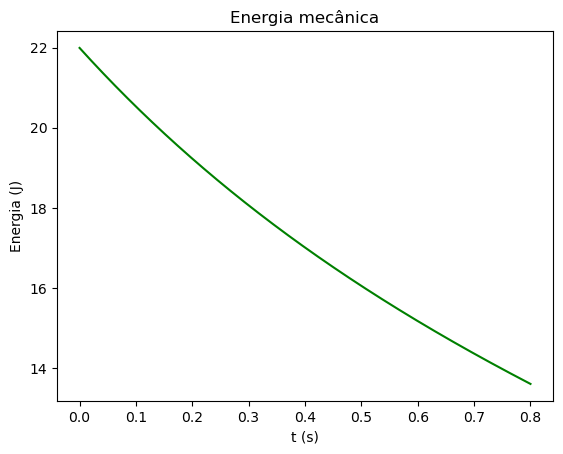

In [12]:
plt.plot(t, E_m, "g")
plt.xlabel("t (s)")
plt.ylabel("Energia (J)")
plt.title("Energia mecânica")
plt.show()

## Parte C

Considerando a resistência do ar, calcule o trabalho realizado pela força de resistência do ar até às posições nos três instantes $t_0 = 0$, $t_1 = 0.4$ e $t_2 = 0.8$ s.

O trabalho é dado pela seguinte expressão:

$$
W = \int_C \vec{F} \cdot \vec{v} \; d\vec{r} = \int_{t_0}^{t_1} F_x \cdot v_x \; dt + \int_{t_0}^{t_1} F_y \cdot v_y \; dt
$$

Para calcular o integral vamos utilizar a aproximação trapezoidal. O vetor da velocidade já sabemos e o vetor da força da resistência do ar podemos facilmente calcular com o método de Euler.

In [43]:
F_res = np.zeros(shape)

# Valores iniciais
F_res[0] = forcaRes(v0)

# Voltar a fazer o método de euler mas apenas para a força da resistência do ar, pois os outros valores já foram calculados
for i in range(n):
    F_res[i + 1] = forcaRes(v[i])

# O trabalho é dado pela força * velocidade, logo fazemos já a multiplicação dos dois arrays
F_times_v = F_res * v

# Loop pelos instantes que queremos medir
for t_i in [0, 0.4, 0.8]:
    # Número de passos a considerar com base no tempo final pretendido
    n_i = int((t_i - t0) / dt)
    
    # Cálculo dos integrais para cada componente do movimento
    W_res_x = dt * ((F_times_v[0, 0] + F_times_v[n_i, 0]) * 0.5 + np.sum(F_times_v[1:n_i, 0]))
    W_res_y = dt * ((F_times_v[0, 1] + F_times_v[n_i, 1]) * 0.5 + np.sum(F_times_v[1:n_i, 1]))
    
    # Trabalho como a soma do trabalho em cada componente
    W_res = W_res_x + W_res_y
    
    print(f"{t_i:0.1f}: {W_res} J")

0.0: -0.0015516666666666665 J
0.4: -4.978670361881312 J
0.8: -8.381340806321727 J


## Parte C (Outro método)

A alínea C também pode ser calculada sem integrais, utilizando o valor da energia mecânica calculado sem resistência do ar, pois este cumpre a seguinte igualdade:

$$
W_{0,1} = \frac{1}{2} m \left\lvert \vec{v_1} \right\rvert^2
- \frac{1}{2} m \left\lvert \vec{v_0} \right\rvert^2
$$

In [44]:
E_orig = 21.99074074

for t_i in [0, 0.4, 0.8]:
    targetIdx = int(np.ceil(t_i / dt))
    W_nc = E_m[targetIdx] - E_orig
    print(f"{t_i:0.1f}: {W_nc:0.2f} J")

0.0: 0.00 J
0.4: -4.98 J
0.8: -8.38 J


# Exercício 2

## Parte A

Nas mesmas condições do problema anterior, repete o calculo do trabalho realizado pela força de resistência do ar no instante $t_1 = 0.4 \; \text{s}$, usando os seguintes valores de $\delta t$:

$$
\{0.1,0.01,0.001,0.0001,0.00001\}
$$


In [90]:
dts = np.array([0.1,0.01,0.001,0.0001,0.00001])
W_res = np.zeros(len(dts))

for idx, dt in enumerate(dts):
    # Parâmetros
    t0 = 0
    tf = 0.4
    
    # Número de passos/iterações
    #
    # + 0.1 para garantir que não há arrendodamentos
    # para baixo
    n = int((tf-t0) / dt + 0.1)
    # Movimento 2D
    shape = (n + 1, 2)

    a = np.zeros(shape)
    v = np.zeros(shape)
    x = np.zeros(shape)
    t = np.zeros(n + 1)
    F_res = np.zeros(shape)


    E_m = np.zeros(n + 1)

    # Valores iniciais
    a[0] = accel(v0)
    v[0] = v0
    x[0] = x0
    t[0] = t0
    F_res[0] = forcaRes(v0)

    for i in range(n):
        a[i + 1] = accel(v[i])
        v[i + 1] = v[i] + a[i] * dt
        x[i + 1] = x[i] + v[i] * dt
        t[i + 1] = t[i] + dt

        F_res[i + 1] = forcaRes(v[i])
    
    # O trabalho é dado pela força * velocidade, logo fazemos já a multiplicação dos dois arrays
    F_times_v = F_res * v
    
    # Cálculo dos integrais para cada componente do movimento
    W_res_x = dt * ((F_times_v[0, 0] + F_times_v[n, 0]) * 0.5 + np.sum(F_times_v[1:n, 0]))
    W_res_y = dt * ((F_times_v[0, 1] + F_times_v[n, 1]) * 0.5 + np.sum(F_times_v[1:n, 1]))
    
    W_res_dt = W_res_x + W_res_y
    
    W_res[idx] = W_res_dt
    print(f"{dt}: {W_res_dt}")

0.1: -5.253617635720338
0.01: -5.003645126523292
0.001: -4.979517965488731
0.0001: -4.977118695214646
1e-05: -4.97687890557073


## Parte B

Faça um plot em escala log-log do erro $\left\lvert W^{(\delta t)} - W^\text{(exato)} \right\rvert$ nos valores do trabalho calculado em a), em função de $\delta t$.

Para o valor exato do trabalho use $W^\text{(exato)} = -4.9768522 \; \text{J}$

Qual é a ordem do erro em termos de $\delta t$?

In [1]:
W_exato = -4.9768522
dif = np.abs(W_res - W_exato)

log_dts = np.log2(dts)
log_dif = np.log2(dif)

plt.plot(log_dts, log_dif, "r+")
plt.xlabel("log(t)")
plt.ylabel("log(Energia)")
plt.title("Erro")
plt.show()

NameError: name 'np' is not defined

A ordem do termo $\delta t$ pode ser obtida através do declive da regressão linear do gráfico log-log:

$$
\log (y) = \log \left(c{\delta t}^n\right) = \log c + n\log {\delta t}
$$

In [92]:
res = linreg(log_dts, log_dif)
print(res.m)

1.003335071378553


## Parte C

Repete alinhas a) e b) usando a aproximação retangular para calcular os integrais. Qual o ordem do erro? Qual dos métodos é preferível usar?

O código é equivalente apenas é adicionado um loop exterior para calcular com cada $\delta t$

In [87]:
dts = np.array([0.1,0.01,0.001,0.0001,0.00001])
W_res = np.zeros(len(dts))

for idx, dt in enumerate(dts):
    # Parâmetros
    t0 = 0
    tf = 0.4
    
    # Número de passos/iterações
    #
    # + 0.1 para garantir que não há arrendodamentos
    # para baixo
    n = int((tf-t0) / dt + 0.1)
    # Movimento 2D
    shape = (n + 1, 2)

    a = np.zeros(shape)
    v = np.zeros(shape)
    x = np.zeros(shape)
    t = np.zeros(n + 1)
    F_res = np.zeros(shape)


    E_m = np.zeros(n + 1)

    # Valores iniciais
    a[0] = accel(v0)
    v[0] = v0
    x[0] = x0
    t[0] = t0
    F_res[0] = forcaRes(v0)

    for i in range(n):
        a[i + 1] = accel(v[i])
        v[i + 1] = v[i] + a[i] * dt
        x[i + 1] = x[i] + v[i] * dt
        t[i + 1] = t[i] + dt

        F_res[i + 1] = forcaRes(v[i])
    
    # O trabalho é dado pela força * velocidade, logo fazemos já a multiplicação dos dois arrays
    F_times_v = F_res * v
    
    # Cálculo dos integrais para cada componente do movimento
    W_res_x = dt * np.sum(F_times_v[0:n, 0])
    W_res_y = dt * np.sum(F_times_v[0:n, 1])
    
    W_res_dt = W_res_x + W_res_y
    
    W_res[idx] = W_res_dt
    print(f"{dt}: {W_res_dt}")

0.1: -5.511672036324359
0.01: -5.031024813421938
0.001: -4.982267179395241
0.0001: -4.97739372587815
1e-05: -4.976906409726722


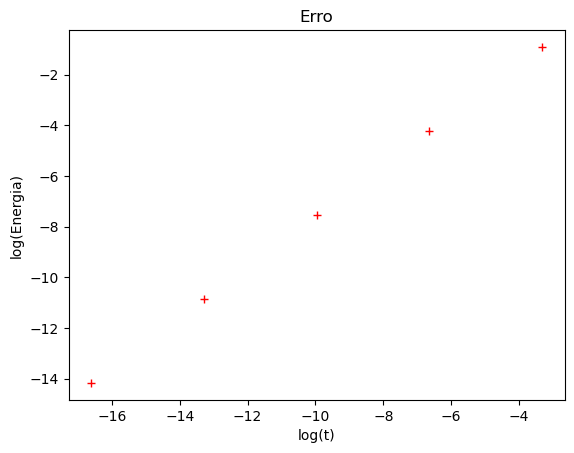

In [88]:
W_exato = -4.9768522
dif = np.abs(W_res - W_exato)

log_dts = np.log2(dts)
log_dif = np.log2(dif)

plt.plot(log_dts, log_dif, "r+")
plt.xlabel("log(t)")
plt.ylabel("log(Energia)")
plt.title("Erro")
plt.show()

In [89]:
res = linreg(log_dts, log_dif)
print(res.m)

0.9988421149842602


A aproximação do trapézio apresenta um erro em termo de $\delta t$ com ordem maior que a aproximação de retângulos.